In [19]:
import pandas as pd
from datetime import datetime
import numpy as np
from itertools import product

from tqdm import tqdm_notebook

import random

import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pylab import rcParams

import seaborn as sns

from sklearn import metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Subset

# import statsmodels.api as sm
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import acf, pacf
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

from scipy import stats

In [2]:
train = pd.read_csv("sales_train_validation.csv")
sell_prices = pd.read_csv("sell_prices.csv")
calendar = pd.read_csv("calendar.csv")
# validation contains 28 more dates
validation = pd.read_csv("sales_train_evaluation.csv")

# Selecting one time series (item 6780)

In [3]:
d_cols = [c for c in train.columns if 'd_' in c]
dates = calendar[calendar.d.isin(d_cols)]['date']
dates_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [4]:
df_sales = train[d_cols].T
df_sales.columns = train['id'].values

df_sales = pd.DataFrame(df_sales).set_index([dates_list])
df_sales.index = pd.to_datetime(df_sales.index)
df_sales.head()

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0


In [5]:
#Select arbitrary index and plot the time series
index = 6780
sales = pd.DataFrame(df_sales.iloc[:,index])
sales = pd.DataFrame(sales).set_index([dates_list])
TS_selected = sales
sales.index = pd.to_datetime(sales.index)
print(sales.shape)

(1913, 1)


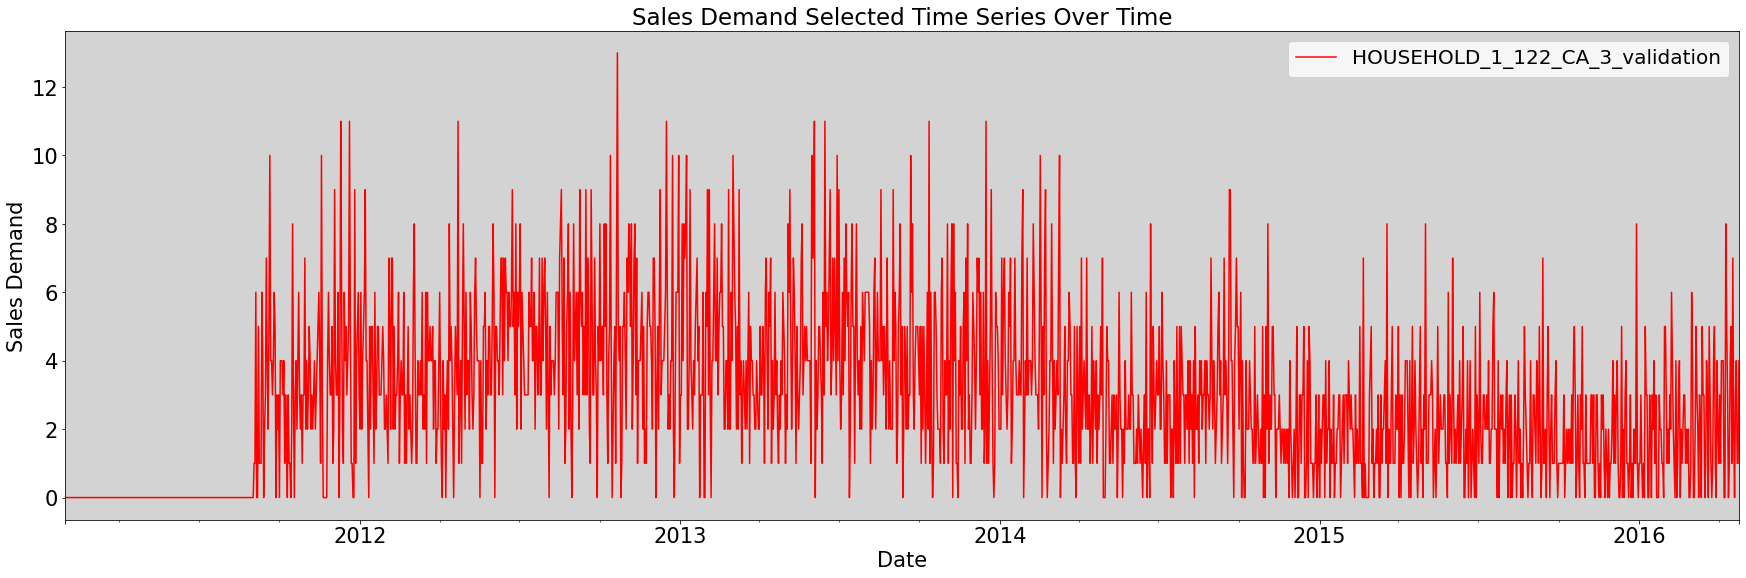

In [6]:
ax = sales.plot(figsize=(30, 9),color='red')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [7]:
sales.iloc[200:].head(20)

,HOUSEHOLD_1_122_CA_3_validation
2011-08-17,0
2011-08-18,0
2011-08-19,0
2011-08-20,0
2011-08-21,0
2011-08-22,0
2011-08-23,0
2011-08-24,0
2011-08-25,0
2011-08-26,0


use data from 2011-09-01

In [8]:
sales = sales.iloc[215:]

In [9]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

## Dara Preprocessing

### Data Normalization

In [10]:
from sklearn.preprocessing import MinMaxScaler

data = np.array(sales)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [11]:
train_data_normalized.shape

(1698, 1)

### Create Single-Step Window

In [12]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [13]:
seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1670, 28, 1)
(1670, 1)


### Changing Data into Tensors

In [14]:
train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

# Variable is a wrapper to the tensor
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [15]:
print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1169, 28, 1])
train label shape is: torch.Size([1169, 1])
test shape is: torch.Size([501, 28, 1])
test label shape is: torch.Size([501, 1])


### Creating LSTM Model

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [18]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(lstm, 'Models\lstm_best.pth')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Input as Batch of 128

In [34]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float)
        self.y = torch.tensor(np.array(y), dtype=torch.float)
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

In [35]:
train_data = CustomDataset(x[:train_size], y[:train_size])
val_data = CustomDataset(x[train_size:len(x)], y[train_size:len(y)])

In [36]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False, drop_last=True)

In [37]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(lstm, 'Models\lstm_best_batch.pth')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [38]:
#####  Parameters  ######################
num_epochs = 1000
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

##### Early Stopper ########################
early_stopper = EarlyStopper(patience=20)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

train_loss_, val_loss_ = [], []
for epoch in range(num_epochs): 
    
    train_loss, val_loss = 0, 0
    
    lstm.train()
    for _, (X, Y) in enumerate(train_loader):
        outputs = lstm(X.to(device))

        # obtain the loss function
        loss = criterion(outputs, Y.to(device))
        train_loss += loss.item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss/=len(train_loader.dataset)
    train_loss_.append(train_loss)
    
    #Evaluate on test     
    lstm.eval()
    with torch.no_grad():
        for _, (X, Y) in enumerate(val_loader):
            valid = lstm(X.to(device))
            loss = criterion(valid, Y.to(device))
            val_loss += loss.item()
    val_loss/=len(val_loader.dataset)
    val_loss_.append(val_loss)
    scheduler.step(val_loss)

    if early_stopper.early_stop(val_loss):
        print("Early Stopping!")
        print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch+1, train_loss,val_loss))
        early_stopped = epoch+1
        break
    
    if epoch % 50 == 0:
      print("Epoch: %d, train loss: %1.5f valid loss:  %1.5f " %(epoch, train_loss,val_loss))

Epoch: 0, train loss: 0.00152 valid loss:  0.00145 
Epoch: 50, train loss: 0.00109 valid loss:  0.00066 
Early Stopping!
Epoch: 54, loss: 0.00112 valid loss:  0.00068 


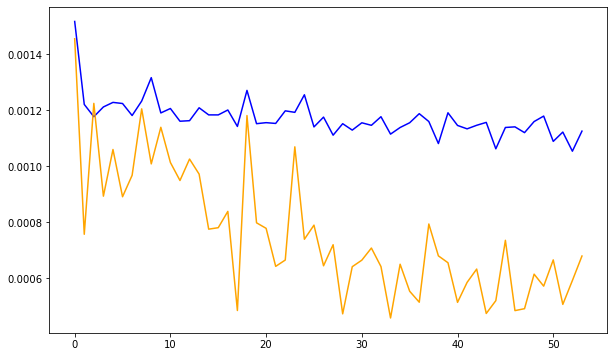

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_, label="Train Loss", color='blue')
plt.plot(val_loss_, label="Validation Loss", color='orange')
plt.show()

In [40]:
lstm = torch.load('Models\lstm_best_batch.pth')

In [41]:
lstm.eval()
with torch.no_grad():
    predict = lstm(dataX.to(device))
predicted = predict.cpu().data.numpy()
predicted_ = list(predicted.reshape(predicted.shape[0]))

In [42]:
forecasts_ = []

forecast_input = train_data_normalized[train_data_normalized.shape[0]-28:train_data_normalized.shape[0]+1]
print(forecast_input.shape)

forecast_input_tensor = Variable(torch.Tensor(np.array(forecast_input))).unsqueeze(0)
print(forecast_input_tensor.shape)

lstm.eval()
with torch.no_grad():
    forecasted = lstm(forecast_input_tensor.to(device))
forecasts_.append(forecasted.cpu().data.numpy()[0][0])

for i in range(27):
    forecast_input_tensor = torch.cat((forecast_input_tensor[:, 1:].to(device), forecasted.unsqueeze(0)), dim = 1)
    lstm.eval()
    with torch.no_grad():
        forecasted = lstm(forecast_input_tensor.to(device))
    forecasts_.append(forecasted.cpu().data.numpy()[0][0])

(28, 1)
torch.Size([1, 28, 1])


In [43]:
all_prediction = predicted_+forecasts_

In [44]:
prediction_df = pd.DataFrame()
prediction_df['sales'] = scaler.inverse_transform(np.array(all_prediction).reshape(-1, 1)).reshape(-1)

prediction_df.index = sales_validation.index[28:]

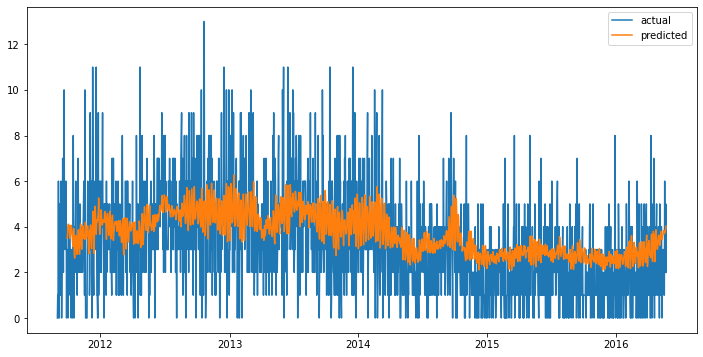

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(sales_validation, label='actual')
plt.plot(prediction_df, label='predicted')
plt.legend()
plt.show()

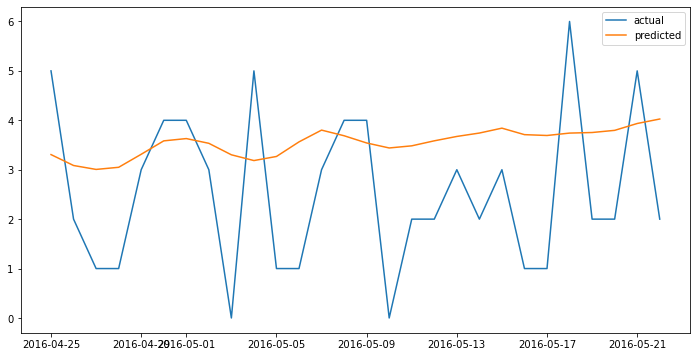

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(sales_validation[-28:], label='actual')
plt.plot(prediction_df[-28:], label='predicted')
plt.legend()
plt.show()

In [47]:
print("RMSE (train): ", np.sqrt(mean_squared_error(sales_validation[28:-28], prediction_df[:-28])))
print("R2 Score (train): ", r2_score(sales_validation[28:-28], prediction_df[:-28]))
print("RMSE (test): ", np.sqrt(mean_squared_error(sales_validation[-28:], prediction_df[-28:])))
print("R2 Score (test): ", r2_score(sales_validation[-28:], prediction_df[-28:]))

RMSE (train):  2.0625074708052367
R2 Score (train):  0.17933782414065813
RMSE (test):  1.8106945846575317
R2 Score (test):  -0.33321268934852677


# Hyperparameter Tuning (item 6780)

## Finding Optimal Batch Size

In [25]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(lstm, 'Models\lstm_best_batch.pth')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [22]:
d_cols = [c for c in validation.columns if 'd_' in c]
dates = calendar[calendar.d.isin(d_cols)]['date']
dates_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

df_validation = validation[d_cols].T
df_validation.columns = validation['id'].values

df_validation = pd.DataFrame(df_validation).set_index([dates_list])
df_validation.index = pd.to_datetime(df_validation.index)

#Select arbitrary index and plot the time series
sales_validation = pd.DataFrame(df_validation.iloc[:,index])
sales_validation = pd.DataFrame(sales_validation).set_index([dates_list])
sales_validation.index = pd.to_datetime(sales_validation.index)

sales_validation = sales_validation.iloc[215:]
print(sales_validation.shape)

(1726, 1)


In [19]:
def generate_cv_folds(train_data):
    # YOUR CODE HERE
    cv = KFold(n_splits=FOLDS, shuffle=True, random_state=1345)
        
    train_, val_ = [], []

    
    for train_idx, val_idx in cv.split(train_data):
        train_set = Subset(train_data,train_idx)
        val_set = Subset(train_data,val_idx)
        
        train_.append(train_set)
        val_.append(val_set)

    return train_, val_

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float)
        self.y = torch.tensor(np.array(y), dtype=torch.float)
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

In [20]:
batch_sizes = [16, 32, 64, 128, 256, 512]

In [26]:
train_rmse_, test_rmse_, train_r2_, test_r2_ = [], [], [], []

data = CustomDataset(x, y)
FOLDS = 3
train_, val_ = generate_cv_folds(data)

for batch_size in batch_sizes:
    #####  Parameters  ######################
    num_epochs = 200
    learning_rate = 1e-3
    input_size = 1
    hidden_size = 512
    num_layers = 1
    num_classes = 1
    train_rmse_2, test_rmse_2, train_r2_2, test_r2_2 = [], [], [], []
    for k in range(FOLDS):
        train_loader = DataLoader(train_[k], batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_[k], batch_size=batch_size, shuffle=False, drop_last=True)
        
        #####Init the Model #######################
        lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
        lstm.to(device)
        
        ##### Early Stopper ########################
        early_stopper = EarlyStopper(patience=20)
        
        ##### Set Criterion Optimzer and scheduler ####################
        criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=20,factor =0.1 ,min_lr=1e-7, eps=1e-08)
        #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
        # Train the model
        train_loss_, val_loss_ = [], []
        for epoch in range(num_epochs): 
            train_loss, val_loss = 0, 0
            lstm.train()
            for _, (X, Y) in enumerate(train_loader):
                outputs = lstm(X.to(device))
                # obtain the loss function
                loss = criterion(outputs, Y.to(device))
                train_loss += loss.item()
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_loss/=len(train_loader.dataset)
            train_loss_.append(train_loss)
            #Evaluate on test     
            lstm.eval()
            with torch.no_grad():
                for _, (X, Y) in enumerate(val_loader):
                    valid = lstm(X.to(device))
                    loss = criterion(valid, Y.to(device))
                    val_loss += loss.item()
            val_loss/=len(val_loader.dataset)
            val_loss_.append(val_loss)
            scheduler.step(val_loss)
            if early_stopper.early_stop(val_loss):
                early_stopped = epoch+1
                break
        lstm = torch.load('Models\lstm_best_batch.pth')
        lstm.eval()
        with torch.no_grad():
            predict = lstm(dataX.to(device))
        predicted = predict.cpu().data.numpy()
        predicted_ = list(predicted.reshape(predicted.shape[0]))
    
        forecasts_ = []    
        forecast_input = train_data_normalized[train_data_normalized.shape[0]-28:train_data_normalized.shape[0]+1]
        forecast_input_tensor = Variable(torch.Tensor(np.array(forecast_input))).unsqueeze(0)
        lstm.eval()
        with torch.no_grad():
            forecasted = lstm(forecast_input_tensor.to(device))
        forecasts_.append(forecasted.cpu().data.numpy()[0][0])
        for i in range(27):
            forecast_input_tensor = torch.cat((forecast_input_tensor[:, 1:].to(device), forecasted.unsqueeze(0)), dim = 1)
            lstm.eval()
            with torch.no_grad():
                forecasted = lstm(forecast_input_tensor.to(device))
            forecasts_.append(forecasted.cpu().data.numpy()[0][0])
        all_prediction = predicted_+forecasts_
        prediction_df = pd.DataFrame()
        prediction_df['sales'] = scaler.inverse_transform(np.array(all_prediction).reshape(-1, 1)).reshape(-1)
        prediction_df.index = sales_validation.index[28:]

        train_rmse_2.append(np.sqrt(mean_squared_error(sales_validation[28:-28], prediction_df[:-28])))
        test_rmse_2.append(np.sqrt(mean_squared_error(sales_validation[-28:], prediction_df[-28:])))
        train_r2_2.append(r2_score(sales_validation[28:-28], prediction_df[:-28]))
        test_r2_2.append( r2_score(sales_validation[-28:], prediction_df[-28:]))
        print(f"{k+1} Fold Batch Size {batch_size}:  Done!!!")
        print(f"rmse: {test_rmse_2[k]}, r2: {test_r2_2[k]}")
        
    train_rmse_.append(np.mean(train_rmse_2))
    test_rmse_.append(np.mean(test_rmse_2))
    train_r2_.append(np.mean(train_r2_2))
    test_r2_.append(np.mean(test_r2_2))

1 Fold Batch Size 16:  Done!!!
rmse: 1.6208465771121694, r2: -0.06829906805207964
2 Fold Batch Size 16:  Done!!!
rmse: 1.596160016359811, r2: -0.03600508791254664
3 Fold Batch Size 16:  Done!!!
rmse: 1.6269419460001522, r2: -0.07634908454011091
1 Fold Batch Size 32:  Done!!!
rmse: 1.6826452381006145, r2: -0.15131497815627393
2 Fold Batch Size 32:  Done!!!
rmse: 1.9449080187048542, r2: -0.5381800237336074
3 Fold Batch Size 32:  Done!!!
rmse: 1.5472967958593349, r2: 0.026454428636085825
1 Fold Batch Size 64:  Done!!!
rmse: 1.6709133617078369, r2: -0.13531636227680877
2 Fold Batch Size 64:  Done!!!
rmse: 1.7831494497231957, r2: -0.29295830740546625
3 Fold Batch Size 64:  Done!!!
rmse: 1.6116832473474467, r2: -0.05625412115552009
1 Fold Batch Size 128:  Done!!!
rmse: 1.68046641668543, r2: -0.14833528218067138
2 Fold Batch Size 128:  Done!!!
rmse: 1.6291908610940051, r2: -0.07932680690239913
3 Fold Batch Size 128:  Done!!!
rmse: 1.6776012153851234, r2: -0.14442278884000448
1 Fold Batch Size

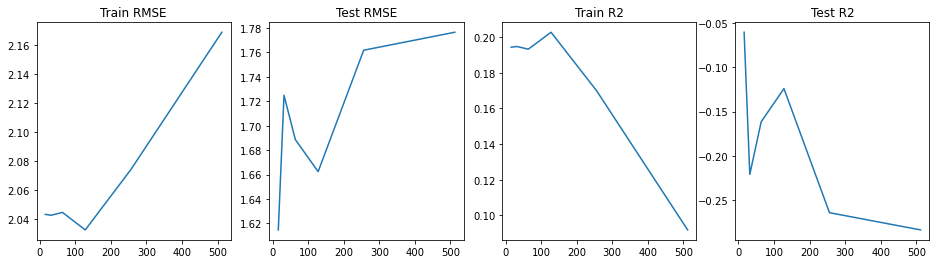

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(batch_sizes, train_rmse_)
ax[0].title.set_text('Train RMSE')
ax[1].plot(batch_sizes, test_rmse_)
ax[1].title.set_text('Test RMSE')
ax[2].plot(batch_sizes, train_r2_)
ax[2].title.set_text('Train R2')
ax[3].plot(batch_sizes, test_r2_)
ax[3].title.set_text('Test R2')
fig.show()

In [28]:
optimal_batch_size = 16

## Finding Optimal Hidden Neurons

In [29]:
hidden_neurons = [32, 64, 128, 256, 512, 1024]

In [30]:
train_rmse_, test_rmse_, train_r2_, test_r2_ = [], [], [], []

data = CustomDataset(x, y)
FOLDS = 3
train_, val_ = generate_cv_folds(data)

for hidden_neuron in hidden_neurons:
    #####  Parameters  ######################
    num_epochs = 200
    learning_rate = 1e-3
    input_size = 1
    hidden_size = hidden_neuron
    num_layers = 1
    num_classes = 1

    train_rmse_2, test_rmse_2, train_r2_2, test_r2_2 = [], [], [], []
    for k in range(FOLDS):
        train_loader = DataLoader(train_[k], batch_size=optimal_batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_[k], batch_size=optimal_batch_size, shuffle=False, drop_last=True)
        
        #####Init the Model #######################
        lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
        lstm.to(device)
        
        ##### Early Stopper ########################
        early_stopper = EarlyStopper(patience=20)
        
        ##### Set Criterion Optimzer and scheduler ####################
        criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=20,factor =0.1,min_lr=1e-7, eps=1e-08)
        #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
        # Train the model
        train_loss_, val_loss_ = [], []
        for epoch in range(num_epochs): 
            train_loss, val_loss = 0, 0
            lstm.train()
            for _, (X, Y) in enumerate(train_loader):
                outputs = lstm(X.to(device))
                # obtain the loss function
                loss = criterion(outputs, Y.to(device))
                train_loss += loss.item()
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_loss/=len(train_loader.dataset)
            train_loss_.append(train_loss)
            #Evaluate on test     
            lstm.eval()
            with torch.no_grad():
                for _, (X, Y) in enumerate(val_loader):
                    valid = lstm(X.to(device))
                    loss = criterion(valid, Y.to(device))
                    val_loss += loss.item()
            val_loss/=len(val_loader.dataset)
            val_loss_.append(val_loss)
            scheduler.step(val_loss)
            if early_stopper.early_stop(val_loss):
                early_stopped = epoch+1
                break
        lstm = torch.load('Models\lstm_best_batch.pth')
        lstm.eval()
        with torch.no_grad():
            predict = lstm(dataX.to(device))
        predicted = predict.cpu().data.numpy()
        predicted_ = list(predicted.reshape(predicted.shape[0]))
    
        forecasts_ = []    
        forecast_input = train_data_normalized[train_data_normalized.shape[0]-28:train_data_normalized.shape[0]+1]
        forecast_input_tensor = Variable(torch.Tensor(np.array(forecast_input))).unsqueeze(0)
        lstm.eval()
        with torch.no_grad():
            forecasted = lstm(forecast_input_tensor.to(device))
        forecasts_.append(forecasted.cpu().data.numpy()[0][0])
        for i in range(27):
            forecast_input_tensor = torch.cat((forecast_input_tensor[:, 1:].to(device), forecasted.unsqueeze(0)), dim = 1)
            lstm.eval()
            with torch.no_grad():
                forecasted = lstm(forecast_input_tensor.to(device))
            forecasts_.append(forecasted.cpu().data.numpy()[0][0])
        all_prediction = predicted_+forecasts_
        prediction_df = pd.DataFrame()
        prediction_df['sales'] = scaler.inverse_transform(np.array(all_prediction).reshape(-1, 1)).reshape(-1)
        prediction_df.index = sales_validation.index[28:]

        train_rmse_2.append(np.sqrt(mean_squared_error(sales_validation[28:-28], prediction_df[:-28])))
        test_rmse_2.append(np.sqrt(mean_squared_error(sales_validation[-28:], prediction_df[-28:])))
        train_r2_2.append(r2_score(sales_validation[28:-28], prediction_df[:-28]))
        test_r2_2.append( r2_score(sales_validation[-28:], prediction_df[-28:]))
        print(f"{k+1} Fold Hidden Neurons Size {hidden_neuron}:  Done!!!")
        print(f"rmse: {test_rmse_2[k]}, r2: {test_r2_2[k]}")
        
    train_rmse_.append(np.mean(train_rmse_2))
    test_rmse_.append(np.mean(test_rmse_2))
    train_r2_.append(np.mean(train_r2_2))
    test_r2_.append(np.mean(test_r2_2))

1 Fold Hidden Neurons Size 32:  Done!!!
rmse: 1.551717189649164, r2: 0.02088393696280244
2 Fold Hidden Neurons Size 32:  Done!!!
rmse: 1.6831598963766294, r2: -0.15201937428845436
3 Fold Hidden Neurons Size 32:  Done!!!
rmse: 1.591081704863511, r2: -0.029423307767780127
1 Fold Hidden Neurons Size 64:  Done!!!
rmse: 1.5116201046094786, r2: 0.07083177018822406
2 Fold Hidden Neurons Size 64:  Done!!!
rmse: 1.6576178228305667, r2: -0.11732070939179984
3 Fold Hidden Neurons Size 64:  Done!!!
rmse: 1.5859299580927722, r2: -0.022767782297352435
1 Fold Hidden Neurons Size 128:  Done!!!
rmse: 1.7316517151563873, r2: -0.21935490014604841
2 Fold Hidden Neurons Size 128:  Done!!!
rmse: 1.5772877464824824, r2: -0.011651411825606584
3 Fold Hidden Neurons Size 128:  Done!!!
rmse: 1.5562684726515605, r2: 0.015131897182640408
1 Fold Hidden Neurons Size 256:  Done!!!
rmse: 1.6661194048763377, r2: -0.1288111177922706
2 Fold Hidden Neurons Size 256:  Done!!!
rmse: 1.5826837862311915, r2: -0.01858514848760

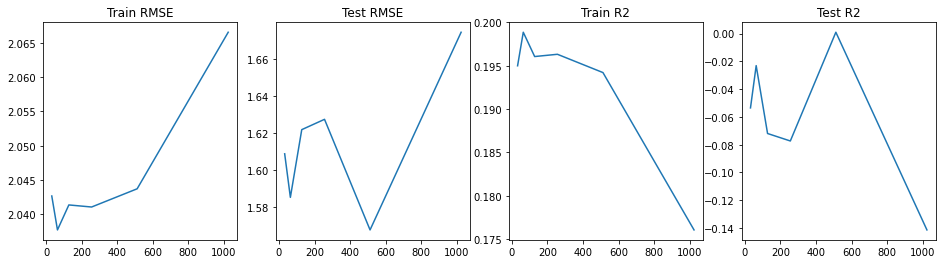

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(hidden_neurons, train_rmse_)
ax[0].title.set_text('Train RMSE')
ax[1].plot(hidden_neurons, test_rmse_)
ax[1].title.set_text('Test RMSE')
ax[2].plot(hidden_neurons, train_r2_)
ax[2].title.set_text('Train R2')
ax[3].plot(hidden_neurons, test_r2_)
ax[3].title.set_text('Test R2')
fig.show()

In [32]:
optimal_hidden_neuron = 512

## Finding Optimal Hidden Layers

In [34]:
hidden_layers = [1, 2, 3, 4, 5, 6]

In [35]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # IMPORTANT: only use the hidden state of the last layer
        h_out = h_out[-1,:,:].view(-1, self.hidden_size)
        out = self.fc(h_out)
        out = self.dropout(out)
        return out

In [36]:
train_rmse_, test_rmse_, train_r2_, test_r2_ = [], [], [], []

data = CustomDataset(x, y)
FOLDS = 3
train_, val_ = generate_cv_folds(data)

for hidden_layer in hidden_layers:
    #####  Parameters  ######################
    num_epochs = 200
    learning_rate = 1e-3
    input_size = 1
    hidden_size = optimal_hidden_neuron
    num_layers = hidden_layer
    num_classes = 1

    train_rmse_2, test_rmse_2, train_r2_2, test_r2_2 = [], [], [], []
    for k in range(FOLDS):
        train_loader = DataLoader(train_[k], batch_size=optimal_batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_[k], batch_size=optimal_batch_size, shuffle=False, drop_last=True)
        
        #####Init the Model #######################
        lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
        lstm.to(device)
        
        ##### Early Stopper ########################
        early_stopper = EarlyStopper(patience=20)
        
        ##### Set Criterion Optimzer and scheduler ####################
        criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=20,factor =0.1,min_lr=1e-7, eps=1e-08)
        #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
        # Train the model
        train_loss_, val_loss_ = [], []
        for epoch in range(num_epochs): 
            train_loss, val_loss = 0, 0
            lstm.train()
            for _, (X, Y) in enumerate(train_loader):
                outputs = lstm(X.to(device))
                # obtain the loss function
                loss = criterion(outputs, Y.to(device))
                train_loss += loss.item()
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_loss/=len(train_loader.dataset)
            train_loss_.append(train_loss)
            #Evaluate on test     
            lstm.eval()
            with torch.no_grad():
                for _, (X, Y) in enumerate(val_loader):
                    valid = lstm(X.to(device))
                    loss = criterion(valid, Y.to(device))
                    val_loss += loss.item()
            val_loss/=len(val_loader.dataset)
            val_loss_.append(val_loss)
            scheduler.step(val_loss)
            if early_stopper.early_stop(val_loss):
                early_stopped = epoch+1
                break
        lstm = torch.load('Models\lstm_best_batch.pth')
        lstm.eval()
        with torch.no_grad():
            predict = lstm(dataX.to(device))
        predicted = predict.cpu().data.numpy()
        predicted_ = list(predicted.reshape(predicted.shape[0]))
    
        forecasts_ = []    
        forecast_input = train_data_normalized[train_data_normalized.shape[0]-28:train_data_normalized.shape[0]+1]
        forecast_input_tensor = Variable(torch.Tensor(np.array(forecast_input))).unsqueeze(0)
        lstm.eval()
        with torch.no_grad():
            forecasted = lstm(forecast_input_tensor.to(device))
        forecasts_.append(forecasted.cpu().data.numpy()[0][0])
        for i in range(27):
            forecast_input_tensor = torch.cat((forecast_input_tensor[:, 1:].to(device), forecasted.unsqueeze(0)), dim = 1)
            lstm.eval()
            with torch.no_grad():
                forecasted = lstm(forecast_input_tensor.to(device))
            forecasts_.append(forecasted.cpu().data.numpy()[0][0])
        all_prediction = predicted_+forecasts_
        prediction_df = pd.DataFrame()
        prediction_df['sales'] = scaler.inverse_transform(np.array(all_prediction).reshape(-1, 1)).reshape(-1)
        prediction_df.index = sales_validation.index[28:]

        train_rmse_2.append(np.sqrt(mean_squared_error(sales_validation[28:-28], prediction_df[:-28])))
        test_rmse_2.append(np.sqrt(mean_squared_error(sales_validation[-28:], prediction_df[-28:])))
        train_r2_2.append(r2_score(sales_validation[28:-28], prediction_df[:-28]))
        test_r2_2.append( r2_score(sales_validation[-28:], prediction_df[-28:]))
        print(f"{k+1} Fold Hidden Layers Size {hidden_layer}:  Done!!!")
        print(f"rmse: {test_rmse_2[k]}, r2: {test_r2_2[k]}")
        
    train_rmse_.append(np.mean(train_rmse_2))
    test_rmse_.append(np.mean(test_rmse_2))
    train_r2_.append(np.mean(train_r2_2))
    test_r2_.append(np.mean(test_r2_2))

1 Fold Hidden Layers Size 1:  Done!!!
rmse: 1.5727570016982324, r2: -0.005847840109127755
2 Fold Hidden Layers Size 1:  Done!!!
rmse: 1.7051162890665885, r2: -0.1822710074918712
3 Fold Hidden Layers Size 1:  Done!!!
rmse: 1.6067199589788619, r2: -0.04975852533170766
1 Fold Hidden Layers Size 2:  Done!!!
rmse: 1.56342219355372, r2: 0.006056773364979562
2 Fold Hidden Layers Size 2:  Done!!!
rmse: 1.5628040320526095, r2: 0.006842608403362593
3 Fold Hidden Layers Size 2:  Done!!!
rmse: 1.5933619413788696, r2: -0.0323760293402271
1 Fold Hidden Layers Size 3:  Done!!!
rmse: 1.755571191176711, r2: -0.25327369425054935
2 Fold Hidden Layers Size 3:  Done!!!
rmse: 1.5854583434710459, r2: -0.02215958327979828
3 Fold Hidden Layers Size 3:  Done!!!
rmse: 1.6994344486133164, r2: -0.17440493619542474
1 Fold Hidden Layers Size 4:  Done!!!
rmse: 1.7140943571446832, r2: -0.19475397339889633
2 Fold Hidden Layers Size 4:  Done!!!
rmse: 1.9177974672322102, r2: -0.49559675635511846
3 Fold Hidden Layers Size

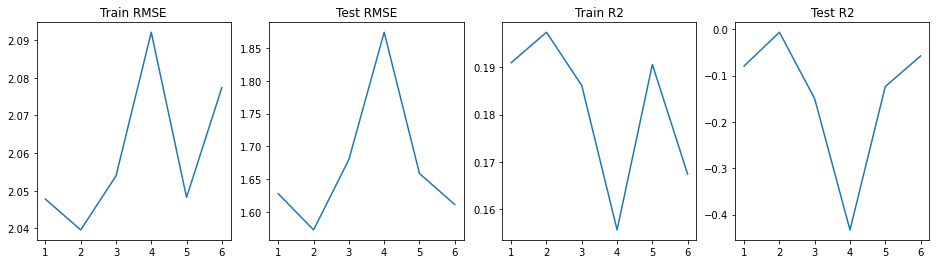

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(hidden_layers, train_rmse_)
ax[0].title.set_text('Train RMSE')
ax[1].plot(hidden_layers, test_rmse_)
ax[1].title.set_text('Test RMSE')
ax[2].plot(hidden_layers, train_r2_)
ax[2].title.set_text('Train R2')
ax[3].plot(hidden_layers, test_r2_)
ax[3].title.set_text('Test R2')
fig.show()

In [38]:
optimal_hidden_layer = 2

## Finding Optimal Lookback Period

In [39]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # IMPORTANT: only use the hidden state of the last layer
        h_out = h_out[-1,:,:].view(-1, self.hidden_size)
        out = self.fc(h_out)
        out = self.dropout(out)
        return out

In [40]:
sequences = [7, 28, 91, 182, 364]

In [43]:
train_rmse_, test_rmse_, train_r2_, test_r2_ = [], [], [], []

for sequence in sequences:
    x, y = sliding_windows(train_data_normalized, sequence)
    
    # Variable is a wrapper to the tensor
    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    data = CustomDataset(x, y)
    FOLDS = 3
    train_, val_ = generate_cv_folds(data)
    
    #####  Parameters  ######################
    num_epochs = 200
    learning_rate = 1e-3
    input_size = 1
    hidden_size = optimal_hidden_neuron
    num_layers = optimal_hidden_layer
    num_classes = 1

    train_rmse_2, test_rmse_2, train_r2_2, test_r2_2 = [], [], [], []
    for k in range(FOLDS):
        train_loader = DataLoader(train_[k], batch_size=optimal_batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_[k], batch_size=optimal_batch_size, shuffle=False, drop_last=True)
        
        #####Init the Model #######################
        lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
        lstm.to(device)
        
        ##### Early Stopper ########################
        early_stopper = EarlyStopper(patience=20)
        
        ##### Set Criterion Optimzer and scheduler ####################
        criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=20,factor =0.1,min_lr=1e-7, eps=1e-08)
        #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
        # Train the model
        train_loss_, val_loss_ = [], []
        for epoch in range(num_epochs): 
            train_loss, val_loss = 0, 0
            lstm.train()
            for _, (X, Y) in enumerate(train_loader):
                outputs = lstm(X.to(device))
                # obtain the loss function
                loss = criterion(outputs, Y.to(device))
                train_loss += loss.item()
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_loss/=len(train_loader.dataset)
            train_loss_.append(train_loss)
            #Evaluate on test     
            lstm.eval()
            with torch.no_grad():
                for _, (X, Y) in enumerate(val_loader):
                    valid = lstm(X.to(device))
                    loss = criterion(valid, Y.to(device))
                    val_loss += loss.item()
            val_loss/=len(val_loader.dataset)
            val_loss_.append(val_loss)
            scheduler.step(val_loss)
            if early_stopper.early_stop(val_loss):
                early_stopped = epoch+1
                break
        lstm = torch.load('Models\lstm_best_batch.pth')
        lstm.eval()
        with torch.no_grad():
            predict = lstm(dataX.to(device))
        predicted = predict.cpu().data.numpy()
        predicted_ = list(predicted.reshape(predicted.shape[0]))
    
        forecasts_ = []    
        forecast_input = train_data_normalized[train_data_normalized.shape[0]-sequence:train_data_normalized.shape[0]+1]
        forecast_input_tensor = Variable(torch.Tensor(np.array(forecast_input))).unsqueeze(0)
        lstm.eval()
        with torch.no_grad():
            forecasted = lstm(forecast_input_tensor.to(device))
        forecasts_.append(forecasted.cpu().data.numpy()[0][0])
        for i in range(27):
            forecast_input_tensor = torch.cat((forecast_input_tensor[:, 1:].to(device), forecasted.unsqueeze(0)), dim = 1)
            lstm.eval()
            with torch.no_grad():
                forecasted = lstm(forecast_input_tensor.to(device))
            forecasts_.append(forecasted.cpu().data.numpy()[0][0])
        all_prediction = predicted_+forecasts_
        prediction_df = pd.DataFrame()
        prediction_df['sales'] = scaler.inverse_transform(np.array(all_prediction).reshape(-1, 1)).reshape(-1)
        prediction_df.index = sales_validation.index[sequence:]

        train_rmse_2.append(np.sqrt(mean_squared_error(sales_validation[sequence:-28], prediction_df[:-28])))
        test_rmse_2.append(np.sqrt(mean_squared_error(sales_validation[-28:], prediction_df[-28:])))
        train_r2_2.append(r2_score(sales_validation[sequence:-28], prediction_df[:-28]))
        test_r2_2.append( r2_score(sales_validation[-28:], prediction_df[-28:]))
        print(f"{k+1} Fold Sequence Length {sequence}:  Done!!!")
        print(f"rmse: {test_rmse_2[k]}, r2: {test_r2_2[k]}")
        
    train_rmse_.append(np.mean(train_rmse_2))
    test_rmse_.append(np.mean(test_rmse_2))
    train_r2_.append(np.mean(train_r2_2))
    test_r2_.append(np.mean(test_r2_2))

1 Fold Sequence Length 7:  Done!!!
rmse: 1.696621852361024, r2: -0.17052082809575664
2 Fold Sequence Length 7:  Done!!!
rmse: 2.0574798523770137, r2: -0.7213937245139386
3 Fold Sequence Length 7:  Done!!!
rmse: 1.7190881959405695, r2: -0.2017257016239662
1 Fold Sequence Length 28:  Done!!!
rmse: 1.830589543318935, r2: -0.3626709189155415
2 Fold Sequence Length 28:  Done!!!
rmse: 1.6426928531446323, r2: -0.09729087700290595
3 Fold Sequence Length 28:  Done!!!
rmse: 1.6938218514584718, r2: -0.1666605042276521
1 Fold Sequence Length 91:  Done!!!
rmse: 1.5671707669283874, r2: 0.0012847599748496696
2 Fold Sequence Length 91:  Done!!!
rmse: 1.5627489928781022, r2: 0.006912561640376569
3 Fold Sequence Length 91:  Done!!!
rmse: 1.563945733734462, r2: 0.00539098219713674
1 Fold Sequence Length 182:  Done!!!
rmse: 1.9100252644785192, r2: -0.4834989961524121
2 Fold Sequence Length 182:  Done!!!
rmse: 1.63341067304185, r2: -0.08492523579704958
3 Fold Sequence Length 182:  Done!!!
rmse: 1.681987084

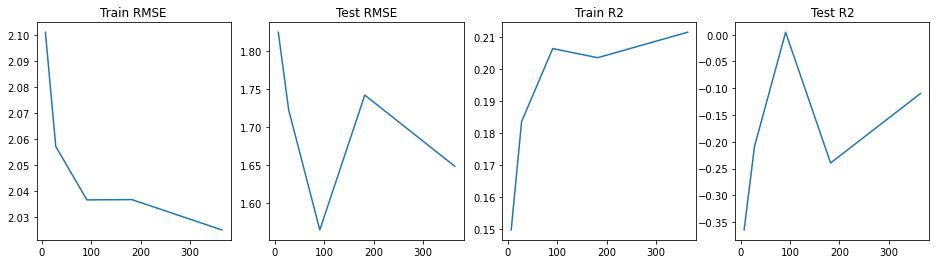

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(sequences, train_rmse_)
ax[0].title.set_text('Train RMSE')
ax[1].plot(sequences, test_rmse_)
ax[1].title.set_text('Test RMSE')
ax[2].plot(sequences, train_r2_)
ax[2].title.set_text('Train R2')
ax[3].plot(sequences, test_r2_)
ax[3].title.set_text('Test R2')
fig.show()

In [45]:
optimal_sequence = 91

## Putting all optimal hyperparameters together

In [20]:
optimal_hidden_neuron = 512
optimal_batch_size = 16
optimal_hidden_layer = 2
optimal_sequence = 91

In [21]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # IMPORTANT: only use the hidden state of the last layer
        h_out = h_out[-1,:,:].view(-1, self.hidden_size)
        out = self.fc(h_out)
        out = self.dropout(out)
        return out

In [22]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float)
        self.y = torch.tensor(np.array(y), dtype=torch.float)
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

In [23]:
seq_length = optimal_sequence
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1607, 91, 1)
(1607, 1)


### Taking 28 days as validation set

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
train_data = CustomDataset(x[:-28], y[:-28])
val_data = CustomDataset(x[-28:len(x)], y[-28:len(y)])

In [26]:
train_loader = DataLoader(train_data, batch_size=optimal_batch_size , shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=optimal_batch_size, shuffle=False, drop_last=False)

In [27]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(lstm, 'Models\lstm_best_6780.pth')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

#### Training Model

In [22]:
#####  Parameters  ######################
num_epochs = 200
learning_rate = 1e-3
input_size = 1
hidden_size = optimal_hidden_neuron
num_layers = optimal_hidden_layer
num_classes = 1

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)
##### Early Stopper ########################
early_stopper = EarlyStopper(patience=20)
##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=20,factor =0.1,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
train_loss_, val_loss_ = [], []
for epoch in range(num_epochs): 
    
    train_loss, val_loss = 0, 0
    
    lstm.train()
    for _, (X, Y) in enumerate(train_loader):
        outputs = lstm(X.to(device))
        # obtain the loss function
        loss = criterion(outputs, Y.to(device))
        train_loss += loss.item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss/=len(train_loader.dataset)
    train_loss_.append(train_loss)
    
    #Evaluate on test     
    lstm.eval()
    with torch.no_grad():
        for _, (X, Y) in enumerate(val_loader):
            valid = lstm(X.to(device))
            loss = criterion(valid, Y.to(device))
            val_loss += loss.item()
    val_loss/=len(val_loader.dataset)
    val_loss_.append(val_loss)
    scheduler.step(val_loss)

    if early_stopper.early_stop(val_loss):
        print("Early Stopping!")
        print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch+1, train_loss,val_loss))
        early_stopped = epoch+1
        break
    
    if epoch % 10 == 0:
      print("Epoch: %d, train loss: %1.5f valid loss:  %1.5f " %(epoch, train_loss,val_loss))

Epoch: 0, train loss: 0.01203 valid loss:  0.01064 
Epoch: 10, train loss: 0.00927 valid loss:  0.00757 
Epoch: 20, train loss: 0.00932 valid loss:  0.00793 
Epoch: 30, train loss: 0.00932 valid loss:  0.00845 
Epoch: 40, train loss: 0.00920 valid loss:  0.00821 
Epoch: 50, train loss: 0.00943 valid loss:  0.00856 
Early Stopping!
Epoch: 52, loss: 0.00941 valid loss:  0.00750 


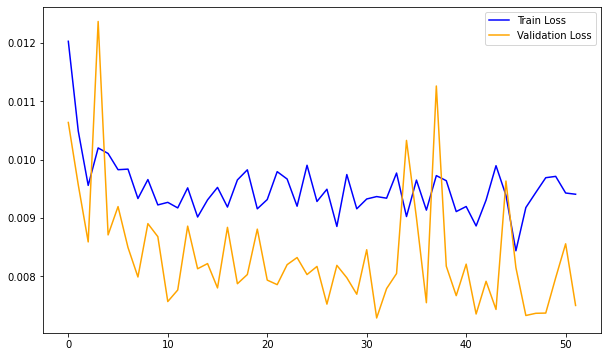

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_, label="Train Loss", color='blue')
plt.plot(val_loss_, label="Validation Loss", color='orange')
plt.legend()
plt.show()

#### Load Pre-Trained Model

In [28]:
lstm = torch.load('Models\lstm_best_6780.pth')

In [29]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

In [30]:
lstm.eval()
with torch.no_grad():
    predict = lstm(dataX.to(device))
predicted = predict.cpu().data.numpy()
predicted_ = list(predicted.reshape(predicted.shape[0]))

In [31]:
len(predicted_)

1607

In [32]:
forecasts_ = []

forecast_input = train_data_normalized[train_data_normalized.shape[0]-28:train_data_normalized.shape[0]+1]
print(forecast_input.shape)

forecast_input_tensor = Variable(torch.Tensor(np.array(forecast_input))).unsqueeze(0)
print(forecast_input_tensor.shape)

lstm.eval()
with torch.no_grad():
    forecasted = lstm(forecast_input_tensor.to(device))
forecasts_.append(forecasted.cpu().data.numpy()[0][0])

for i in range(27):
    forecast_input_tensor = torch.cat((forecast_input_tensor[:, 1:].to(device), forecasted.unsqueeze(0)), dim = 1)
    lstm.eval()
    with torch.no_grad():
        forecasted = lstm(forecast_input_tensor.to(device))
    forecasts_.append(forecasted.cpu().data.numpy()[0][0])

(28, 1)
torch.Size([1, 28, 1])


In [33]:
all_prediction = predicted_+forecasts_

In [34]:
d_cols = [c for c in validation.columns if 'd_' in c]
dates = calendar[calendar.d.isin(d_cols)]['date']
dates_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

df_validation = validation[d_cols].T
df_validation.columns = validation['id'].values

df_validation = pd.DataFrame(df_validation).set_index([dates_list])
df_validation.index = pd.to_datetime(df_validation.index)

#Select arbitrary index and plot the time series
sales_validation = pd.DataFrame(df_validation.iloc[:,index])
sales_validation = pd.DataFrame(sales_validation).set_index([dates_list])
sales_validation.index = pd.to_datetime(sales_validation.index)

sales_validation = sales_validation.iloc[215:]
print(sales_validation.shape)

(1726, 1)


In [35]:
len(all_prediction)

1635

In [36]:
prediction_df = pd.DataFrame()
prediction_df['sales'] = scaler.inverse_transform(np.array(all_prediction).reshape(-1, 1)).reshape(-1)

prediction_df.index = sales_validation.index[seq_length:]

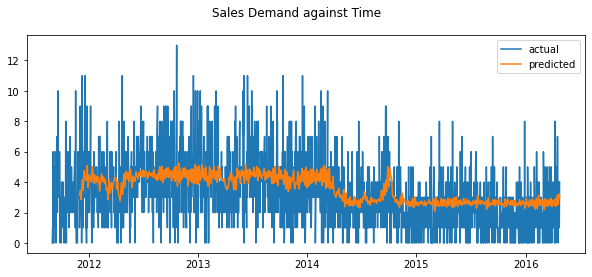

In [46]:
plt.figure(figsize=(10, 4))
plt.plot(sales_validation[:-28], label='actual')
plt.plot(prediction_df[:-28], label='predicted')
plt.suptitle("Sales Demand against Time")
plt.legend()
plt.show()

In [56]:
sales_validation[:-28].mean()

HOUSEHOLD_1_122_CA_3_evaluation    3.233804
dtype: float64

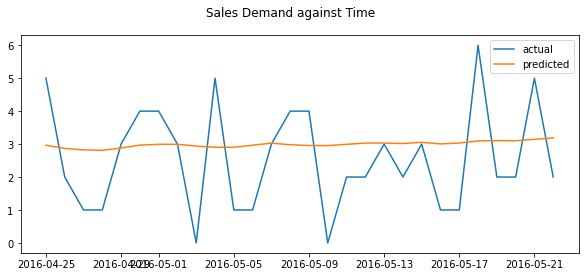

In [52]:
plt.figure(figsize=(10, 4))
plt.plot(sales_validation[-28:], label='actual')
plt.plot(prediction_df[-28:], label='predicted')
plt.suptitle("Sales Demand against Time")
plt.legend()
plt.show()

In [39]:
print("RMSE (train): ", np.sqrt(mean_squared_error(sales_validation[seq_length:-28], prediction_df[:-28])))
print("R2 Score (train): ", r2_score(sales_validation[seq_length:-28], prediction_df[:-28]))
print("RMSE (test): ", np.sqrt(mean_squared_error(sales_validation[-28:], prediction_df[-28:])))
print("R2 Score (test): ", r2_score(sales_validation[-28:], prediction_df[-28:]))

RMSE (train):  2.0450414580929466
R2 Score (train):  0.19975553420050018
RMSE (test):  1.6027978176072695
R2 Score (test):  -0.04463967935439572


In [37]:
prediction_df.to_csv("lstm_best_6780_results.csv", index=False)

## Residual Analysis

In [62]:
sales_validation.columns = ["sales"]

original_prediction_df = prediction_df.iloc[:-28]
original_forecast_df = prediction_df.iloc[-28:]

original_prediction_residuals_df = sales_validation[optimal_sequence:-28]-original_prediction_df
original_forecast_residuals_df = sales_validation[-28:]-original_forecast_df

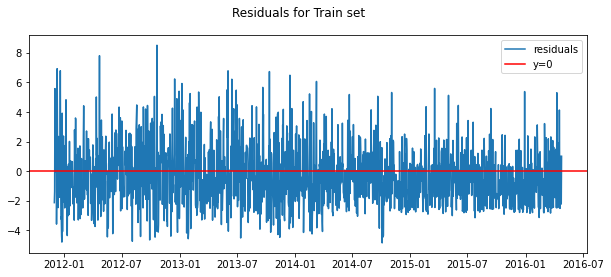

In [69]:
plt.figure(figsize=(10, 4))
plt.plot(original_prediction_residuals_df, label="residuals")
plt.axhline(0, color='red', label="y=0")
plt.suptitle("Residuals for Train set")
plt.legend()
plt.show()

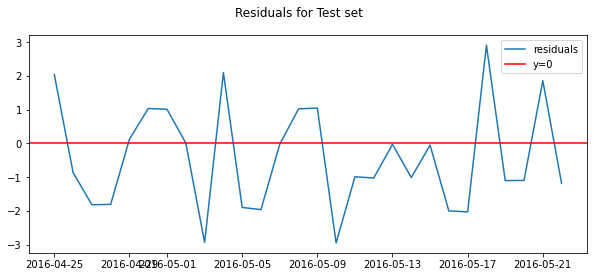

In [70]:
plt.figure(figsize=(10, 4))
plt.plot(original_forecast_residuals_df, label="residuals")
plt.axhline(0, color='red', label="y=0")
plt.suptitle("Residuals for Test set")
plt.legend()
plt.show()